<a href="https://colab.research.google.com/github/MiggieCS911/AllAbouteCovidTH/blob/main/Predict160day_COVID_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from keras.models import Model,

# Load LSTM model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/covid_model/result/CovidPredictionNextDayFrom14day.h5')

# Create prepare data pipeline

In [ ]:
alldf = pd.read_csv('/content/drive/MyDrive/covid_model/data/owid-covid-data_24072021.csv')
df = alldf.loc[alldf['location'] == 'Thailand', ['date','new_cases_per_million']].copy()
df

,date,new_cases_per_million
93418,2020-01-04,NaN
93419,2020-01-05,NaN
93420,2020-01-06,NaN
93421,2020-01-07,NaN
93422,2020-01-08,NaN
...,...,...
93979,2021-07-18,163.281
93980,2021-07-19,168.825
93981,2021-07-20,161.963
93982,2021-07-21,186.275


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 93418 to 93983
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   566 non-null    object 
 1   new_cases_per_million  547 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.3+ KB


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
# get after October 30th,2020 
df= df.loc[300:,:]
df

,date,new_cases_per_million
300,2020-10-30,0.072
301,2020-10-31,0.057
302,2020-11-01,0.043
303,2020-11-02,0.143
304,2020-11-03,0.100
...,...,...
561,2021-07-18,163.281
562,2021-07-19,168.825
563,2021-07-20,161.963
564,2021-07-21,186.275


In [ ]:
df['date'] = pd.to_datetime(df.date)

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
#2021-07-23, 14575; 2021-07-24, 14260
14575/69.93, 14260/69.93

(208.4227084227084, 203.9182039182039)

add 2 recent data

In [ ]:
df.loc[266, 'new_cases_per_million'] = 208.422
df.loc[266,'date'] = pd.to_datetime('2021-07-23')
df.loc[267, 'new_cases_per_million'] = 203.918
df.loc[267,'date'] = pd.to_datetime('2021-07-24')

In [ ]:
df

,date,new_cases_per_million
0,2020-10-30,0.072
1,2020-10-31,0.057
2,2020-11-01,0.043
3,2020-11-02,0.143
4,2020-11-03,0.100
...,...,...
263,2021-07-20,161.963
264,2021-07-21,186.275
265,2021-07-22,195.630
266,2021-07-23,208.422


In [ ]:
#function for create time series data
def createSingleTimeSeries(dataframe, interval, column):
  timeseries = []
  groundtruth = []

  for i in range(interval, len(dataframe)):
    data_interval = dataframe.loc[i - interval: i - 1, column].values
    res = dataframe.loc[i,column]

    timeseries.append(data_interval)
    groundtruth.append(res)

  return timeseries, groundtruth

In [ ]:
#create timeseries data
data,res = createSingleTimeSeries(df,14,'new_cases_per_million')

In [ ]:
data[-1], res[-1]

(array([133.61 , 136.662, 124.012, 124.427, 133.481, 131.605, 138.854,
        144.441, 163.281, 168.825, 161.963, 186.275, 195.63 , 208.422]),
 203.918)

# prepared format of data

In [ ]:
#function for prepare data input to model
def prepdatatomodel(X,y):
  X = np.array(X)
  y = np.array(y)

  X = np.reshape(X, (X.shape[0],X.shape[1] , 1))

  return X,y 

In [ ]:
datanp, resnp = prepdatatomodel(data,res)

In [ ]:
datanp[-1],resnp[-1]

(array([[133.61 ],
        [136.662],
        [124.012],
        [124.427],
        [133.481],
        [131.605],
        [138.854],
        [144.441],
        [163.281],
        [168.825],
        [161.963],
        [186.275],
        [195.63 ],
        [208.422]]), 203.918)

In [ ]:
predict = model.predict(datanp)
predict[-2]

array([196.60547], dtype=float32)

# predict from prediction value

In [ ]:
def prepareSingleTimeSeries(X):
  X = np.array(X)

  X = np.reshape(X, (1,14, 1))

  return X

In [ ]:
#lopp predict for 4 months

tsdata = prepareSingleTimeSeries(datanp[-1])
predict_result = []
noisePred_result = []

for t in range(160): #forward 160 day
  pred = model.predict(tsdata)
  pred = pred[0][0]
  predict_result.append(pred)

  #add noise: increase random error 5 - 12.5% of  predict -> random increase, decrease
  #use random from gaussian distribution
  if t < 80: #first 80 day -> trend to increase
    mu, sigma = 0.025,0.1 #(-0.075,0.125)
    noise = np.random.normal(mu, sigma) #%noise
    noisePred = pred + noise*pred
  elif t >= 80:
    mu, sigma = 0,0.1 #(-0.05,0.15)
    noise = np.random.normal(mu, sigma) #%noise
    noisePred = pred + noise*pred

  noisePred_result.append(noisePred)

  for i in range(tsdata.shape[1]):
    if i < (tsdata.shape[1] - 1):
      tsdata[0][i] = tsdata[0][i+1]
    if i == (tsdata.shape[1] - 1):
      tsdata[0][i] = noisePred
  print(tsdata)
  print(pred)
  print(noisePred)
print(predict_result)
print(noisePred_result)

[[[136.662    ]
  [124.012    ]
  [124.427    ]
  [133.481    ]
  [131.605    ]
  [138.854    ]
  [144.441    ]
  [163.281    ]
  [168.825    ]
  [161.963    ]
  [186.275    ]
  [195.63     ]
  [208.422    ]
  [227.7899944]]]
212.3498
227.7899944015129
[[[124.012     ]
  [124.427     ]
  [133.481     ]
  [131.605     ]
  [138.854     ]
  [144.441     ]
  [163.281     ]
  [168.825     ]
  [161.963     ]
  [186.275     ]
  [195.63      ]
  [208.422     ]
  [227.7899944 ]
  [230.01313695]]]
231.98839
230.01313694853422
[[[124.427     ]
  [133.481     ]
  [131.605     ]
  [138.854     ]
  [144.441     ]
  [163.281     ]
  [168.825     ]
  [161.963     ]
  [186.275     ]
  [195.63      ]
  [208.422     ]
  [227.7899944 ]
  [230.01313695]
  [258.35005792]]]
228.54791
258.35005792268936
[[[133.481     ]
  [131.605     ]
  [138.854     ]
  [144.441     ]
  [163.281     ]
  [168.825     ]
  [161.963     ]
  [186.275     ]
  [195.63      ]
  [208.422     ]
  [227.7899944 ]
  [230.01313695]
  [25

In [ ]:
predict_result_np = np.array(predict_result)

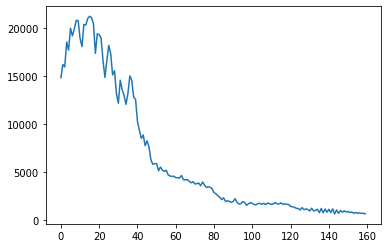

In [ ]:
plt.plot(predict_result_np*69.93)

In [ ]:
temp = list(df['new_cases_per_million'].values * 69.93)

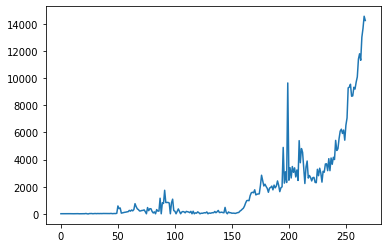

In [ ]:
plt.plot(temp)

In [ ]:
 temp = list(df['new_cases_per_million'].values)

In [ ]:
All = temp + predict_result

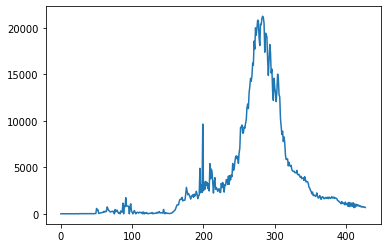

In [ ]:
plt.plot(np.array(All)*69.93)

In [ ]:
listpredict = predict.reshape(-1).tolist()

In [ ]:
allPredict = listpredict + predict_result 

In [ ]:
allPredict

# Plot

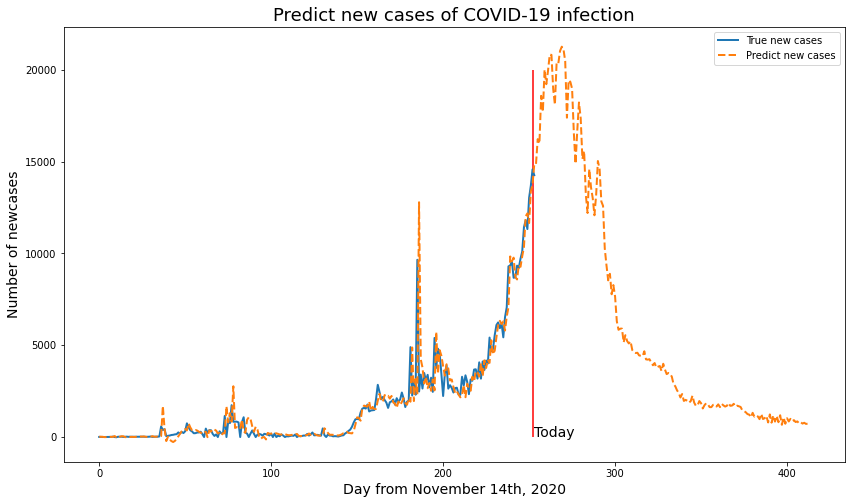

In [ ]:
plt.figure(figsize=(14,8))

plt.plot(np.array(temp[14:])*69.93, label = 'True new cases', linewidth = 2)
plt.plot(np.array(allPredict)*69.93, label = 'Predict new cases', linewidth = 2, linestyle = '--')

plt.title('Predict new cases of COVID-19 infection', fontsize = 18)
plt.ylabel('Number of newcases', fontsize = 14)
plt.xlabel('Day from November 14th, 2020', fontsize = 14)
plt.vlines(252,0,20000, color = 'r')
plt.annotate('Today', (253,0), fontsize = 14)
plt.legend()

# plt.savefig('/content/drive/MyDrive/covid_model/result/predicted160day_covid.png', dpi = 600)
plt.show()